In [1]:
import pandas as pd
import plotnine
from plotnine import *
import seaborn as sns
import numpy as np
import matplotlib as plt


# Plot covariates

In [ ]:
with open("Bauges_data_covariates.csv", newline='') as my_csv:
            data_names = pd.read_csv(my_csv, sep=',', index_col=0)

In [ ]:
list(data_names.columns)

['bio_1_0', 'bio_12_0', 'bio_19_0', 'bio_8_0', 'slope', 'PC1', 'PC2']

In [ ]:
# the best clustering is: applam_d_4_fixed_out/rho_50_ranges_50_out_0
best_clust = pd.read_csv("best_clus.txt", sep=" ", header=None).astype(int)
#best_clust = best_clust.astype("category")

Numerosity of the clusters

In [ ]:
un , count = np.unique(np.array(best_clust[0]), return_counts=True)
count

array([212, 236, 221, 246, 224])

In [ ]:
df_cluster = data_names 
df_cluster.insert(0, "Cluster", best_clust)

In [ ]:
df_cluster["Cluster_fact"] = df_cluster["Cluster"].astype("category")

Box-plots for each of the covariate, with clusters

In [ ]:
bp_1 = ggplot(df_cluster, aes("Cluster_fact", "bio_1_0", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("bio_1_0 distribution among clusters")

bp_2 = ggplot(df_cluster, aes("Cluster_fact", "bio_12_0", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("bio_12_0 distribution among clusters")

bp_3 = ggplot(df_cluster, aes("Cluster_fact", "bio_19_0", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("bio_19_0 distribution among clusters")

bp_4 = ggplot(df_cluster, aes("Cluster_fact", "bio_8_0", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("bio_8_0 distribution among clusters")



In [ ]:
print(bp_1)
print(bp_2)
print(bp_3)
print(bp_4)

In [ ]:
bp_slope = ggplot(df_cluster, aes("Cluster_fact", "slope", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("slope distribution among clusters")

bp_pc1 = ggplot(df_cluster, aes("Cluster_fact", "PC1", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("PC1 distribution among clusters")

bp_pc2 = ggplot(df_cluster, aes("Cluster_fact", "PC2", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("PC2 distribution among clusters")

print(bp_slope)
print(bp_pc1)
print(bp_pc2)

Pair plots 


In [ ]:
sns.pairplot(df_cluster, vars = ['bio_1_0', 'bio_12_0', 'bio_19_0','bio_8_0'], 
             hue = 'Cluster_fact')

# Species distribution within clusters

In [6]:
with open("Bauges_data.csv", newline='') as my_csv:
            data_species = pd.read_csv(my_csv, sep=',', index_col=0)

In [7]:
# the best clustering is: applam_d_4_fixed_out/rho_50_ranges_50_out_0
best_clust = pd.read_csv("best_clus.txt", sep=" ", header=None).astype(int)
#best_clust = best_clust.astype("category")

# Presence/absence relevant species

My index V

In [24]:
# select the relevant species for each cluster

num_rel = 3

nobs = best_clust.shape[0]
nspecies = data_species.shape[1]
nclusters = np.unique(np.array(best_clust[0])).size

# Relevent species (per cluster) in decreasing order and the V index for all the species (not ordered)
pres_species_pc = np.empty(nclusters, dtype=object)
abs_species_pc = np.empty(nclusters, dtype=object)
rel_species_pc = np.empty(nclusters, dtype=object)

V_species_pc = np.empty(nclusters, dtype=object)

data_by_cluster = np.empty(nclusters, dtype=object)
for c in range(nclusters):
  data_by_cluster[c] = np.array([i for i in range(nobs) if best_clust.iloc[i,0]==c])

V = np.empty((nclusters,nspecies))
for j in range(nspecies):
  zj = np.mean(data_species.iloc[:,j]) # proportion of species j in the complete dataset
  for c in range(nclusters):
    zcj = np.mean(data_species.iloc[data_by_cluster[c],j])
    V[c,j] = zcj - zj

### Once computed the index for all the species, take the largest ones
for c in range(nclusters):
  ord_species = np.argsort(V[c,:])[::-1]
  pres_species_pc[c] = ord_species[0:num_rel]
  abs_species_pc[c] = ord_species[(nspecies-num_rel):nspecies]
  rel_species_pc[c] = np.concatenate((pres_species_pc[c],abs_species_pc[c])) 


In [ ]:
### Most relevant species within each group
c1 = np.repeat(range(nclusters), num_rel)
c2_pres = np.concatenate(pres_species_pc)
c2_abs = np.concatenate(abs_species_pc)
df_tmp = pd.DataFrame({ 'cluster': c1 , 'pres_species_pc' : c2_pres, 'abs_species_pc' : c2_abs})

df_tmp['cluster'] = df_tmp['cluster'].astype("category")
df_tmp['pres_species_pc'] = df_tmp['pres_species_pc'].astype("category")
df_tmp['abs_species_pc'] = df_tmp['abs_species_pc'].astype("category")

d_pres = df_tmp.groupby('pres_species_pc')
df_new_pres = d_pres.apply(lambda x: np.array(x.loc[:,'cluster']))

d_abs = df_tmp.groupby('abs_species_pc')
df_new_abs = d_abs.apply(lambda x: np.array(x.loc[:,'cluster']))


print("clusters showing each of the species (Presence): ",df_new_pres)
print("clusters showing each of the species (Absence): ",df_new_abs)



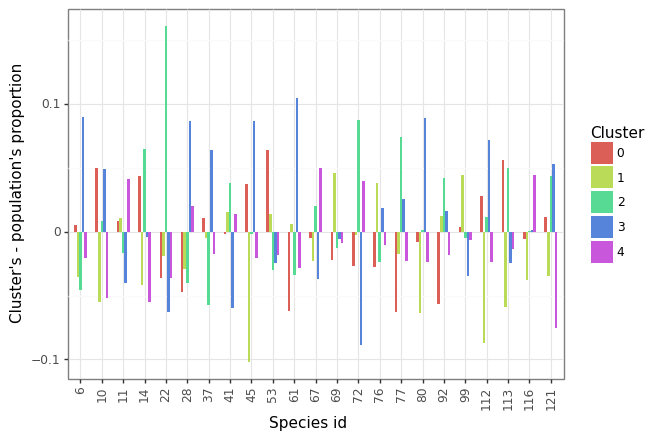

In [89]:
### Plot the results
rel_species = np.unique(np.concatenate(rel_species_pc))
V_rel_species_pc = np.array([V[c,rel_species] for c in range(nclusters)]) 

# Build the dataframe with three columns (cluster, rel_species, V_rel_species)
num_rel_species = rel_species.size

col_cluster = np.repeat(range(nclusters), num_rel_species)
col_rel_species = np.tile(rel_species, nclusters)
col_V_rel_species = V_rel_species_pc.flatten()

df = pd.DataFrame({ 'Cluster': col_cluster , 'rel_species' : col_rel_species, 'V_index': col_V_rel_species})
df['Cluster']=df['Cluster'].astype("category")
df['rel_species']=df['rel_species'].astype("category")

# Barplot with multiple groups
species = ggplot(df, aes("rel_species", "V_index", fill="Cluster")) +  geom_bar(stat="identity", position="dodge", width=0.6) \
  + xlab("Species id") + ylab("Cluster's - population's proportion") \
  + theme_bw() \
  + theme(axis_text_x = element_text(angle=90))
print(species)
species.save("species_and_clusters.pdf")

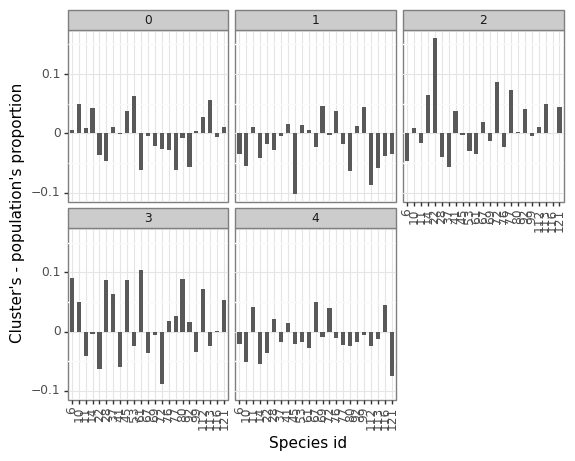

In [88]:
multi_plot = ggplot(df,aes("rel_species", "V_index") ) +  geom_bar(stat="identity", position="dodge", width=0.6) \
  + facet_wrap("Cluster") + xlab("Species id") + ylab("Cluster's - population's proportion") \
  + theme_bw() \
  + theme(axis_text_x = element_text(angle=90))
print(multi_plot)
multi_plot.save("multigraph_clusters.pdf", width=15, height=10, dpi=400)

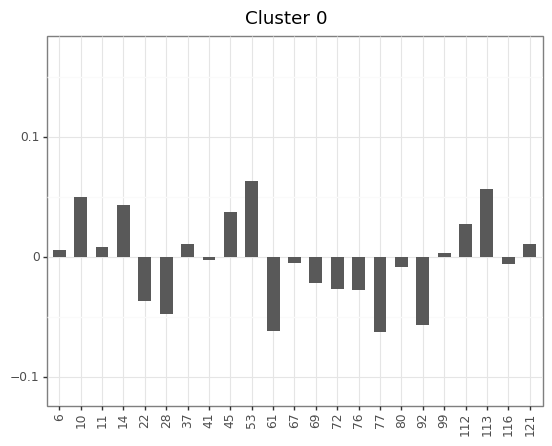

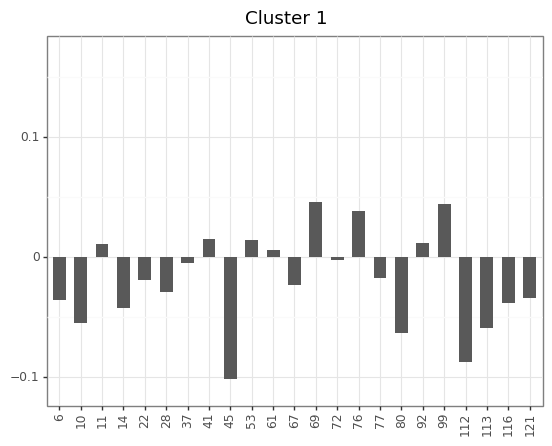

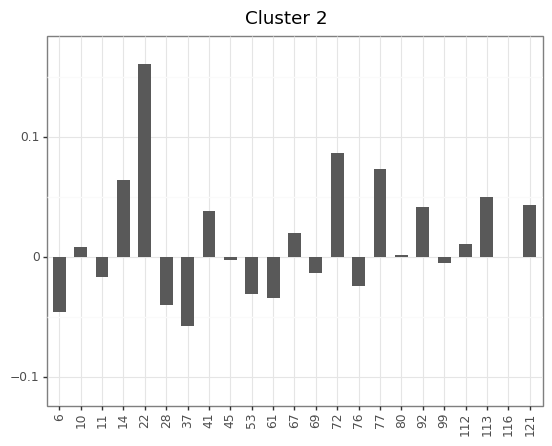

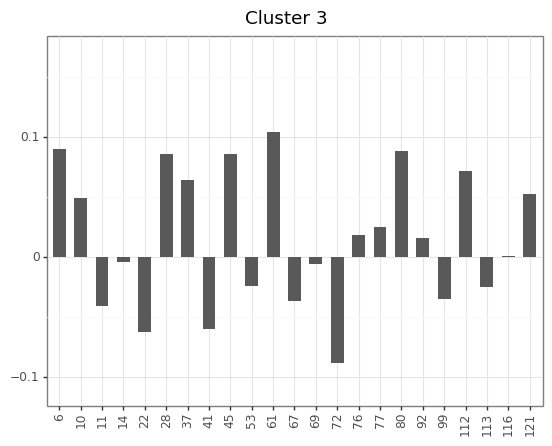

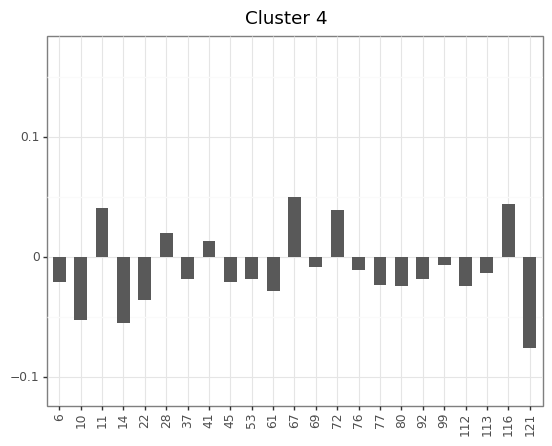

In [87]:
# Plots on different files
g0 = ggplot(df.loc[df["Cluster"]==0],aes("rel_species", "V_index") ) +  geom_bar(stat="identity", position="dodge", width=0.6) \
  + xlab("") + ylab("") + ylim(-0.11,0.17)\
  + theme_bw() \
  + theme(axis_text_x = element_text(angle=90)) + ggtitle("Cluster 0")

g1 = ggplot(df.loc[df["Cluster"]==1],aes("rel_species", "V_index") ) +  geom_bar(stat="identity", position="dodge", width=0.6) \
  + xlab("") + ylab("") + ylim(-0.11,0.17)\
  + theme_bw() \
  + theme(axis_text_x = element_text(angle=90)) + ggtitle("Cluster 1")

g2 = ggplot(df.loc[df["Cluster"]==2],aes("rel_species", "V_index") ) +  geom_bar(stat="identity", position="dodge", width=0.6) \
  + xlab("") + ylab("") + ylim(-0.11,0.17)\
  + theme_bw() \
  + theme(axis_text_x = element_text(angle=90)) + ggtitle("Cluster 2")

g3 = ggplot(df.loc[df["Cluster"]==3],aes("rel_species", "V_index") ) +  geom_bar(stat="identity", position="dodge", width=0.6) \
  + xlab("") + ylab("") + ylim(-0.11,0.17)\
  + theme_bw() \
  + theme(axis_text_x = element_text(angle=90)) + ggtitle("Cluster 3")

g4 = ggplot(df.loc[df["Cluster"]==4],aes("rel_species", "V_index") ) +  geom_bar(stat="identity", position="dodge", width=0.6) \
  + xlab("") + ylab("") + ylim(-0.11,0.17)\
  + theme_bw() \
  + theme(axis_text_x = element_text(angle=90)) + ggtitle("Cluster 4")

print(g0)
print(g1)
print(g2)
print(g3)
print(g4)

g0.save("cluster0_species.pdf")
g1.save("cluster1_species.pdf")
g2.save("cluster2_species.pdf")
g3.save("cluster3_species.pdf")
g4.save("cluster4_species.pdf")


# Presence relevant species

In [8]:
# Define the different indexes V for measuring association

### Compute Cramer's V [But to be substituted with meaningful index]
def cramers(cont):
    #Chi-squared test statistic, sample size, and minimum of rows and columns
    X2 = stats.chi2_contingency(cont, correction=False)[0]
    n = np.sum(cont)
    minDim = min(cont.shape)-1
    #calculate Cramer's V 
    return np.sqrt((X2/n) / minDim)

### Compute the ratio between the number of sites in the cluster where the species is present, over ...
def jaccard(cont):
  return cont[1,1]/(cont[1,1]+cont[0,1]+cont[1,0])


In [ ]:
from scipy.stats.contingency import crosstab
import scipy.stats as stats

num_largest = 5

nobs = best_clust.shape[0]
nspecies = data_species.shape[1]
nclusters = np.unique(np.array(best_clust[0])).size

# Relevent species (per cluster) in decreasing order and the V index for all the species (not ordered)
rel_species_pc = np.empty(nclusters, dtype=object)
V_species_pc = np.empty(nclusters, dtype=object)

for c in range(nclusters):
  ### Create the dummy: 1 if in cluster c, 0 if not in cluster c
  dum = 1*(best_clust == c).to_numpy().reshape(nobs)

  ### Extract each species columns, from the first to the last, and compute index
  V = np.empty(nspecies)
  for s in range(nspecies):
    sp = data_species[data_species.columns[s]].to_numpy()
    res = crosstab(dum,sp)
    cont_t = res[1]
    V[s] = jaccard(cont_t)

  ### Once computed the index for all the species, take the 3 largest ones
  ord_species = np.argsort(V)[::-1]
  rel_species_pc[c] = ord_species[0:num_largest]
  V_species_pc[c] = V



In [ ]:
### Most relevant species within each group
c1 = np.repeat(range(nclusters), num_largest)
c2 = np.concatenate(rel_species_pc)
df_tmp = pd.DataFrame({ 'cluster': c1 , 'rel_species_pc' : c2})

df_tmp['cluster'] = df_tmp['cluster'].astype("category")
df_tmp['rel_species_pc'] = df_tmp['rel_species_pc'].astype("category")

d = df_tmp.groupby('rel_species_pc')
df_new = d.apply(lambda x: np.array(x.loc[:,'cluster']))

print("species in each of the cluster: ", list(rel_species_pc))

print("clusters showing each of the species: ",df_new)



species in each of the cluster:  [array([113,  45,   0, 112,  14]), array([ 61, 113,  45,   0,  99]), array([ 22, 113,  14,  83,  77]), array([ 45,  61,  80, 112,  28]), array([ 45, 113,  28,   0, 112])]
clusters showing each of the species:  rel_species_pc
0         [0, 1, 4]
14           [0, 2]
22              [2]
28           [3, 4]
45     [0, 1, 3, 4]
61           [1, 3]
77              [2]
80              [3]
83              [2]
99              [1]
112       [0, 3, 4]
113    [0, 1, 2, 4]
dtype: object


In [ ]:
data_species.columns[df['rel_species']]

Index(['23', '2740', '4776', '6077', '7895', '9369', '11151', '11726', '11874',
       '15630', '17343', '17363', '23', '2740', '4776', '6077', '7895', '9369',
       '11151', '11726', '11874', '15630', '17343', '17363', '23', '2740',
       '4776', '6077', '7895', '9369', '11151', '11726', '11874', '15630',
       '17343', '17363', '23', '2740', '4776', '6077', '7895', '9369', '11151',
       '11726', '11874', '15630', '17343', '17363', '23', '2740', '4776',
       '6077', '7895', '9369', '11151', '11726', '11874', '15630', '17343',
       '17363'],
      dtype='object')

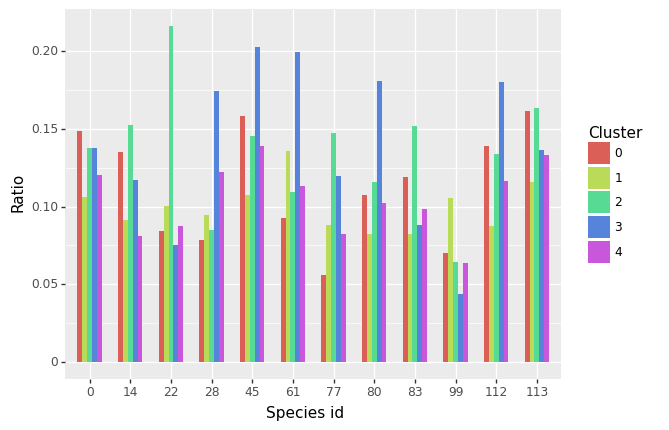

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: species_and_clusters.pdf


In [ ]:
### Plot the results
rel_species = np.unique(np.concatenate(rel_species_pc))
V_rel_species_pc = np.array([V_sp[rel_species] for V_sp in V_species_pc]) 

# Build the dataframe with three columns (cluster, rel_species, V_rel_species)
num_rel_species = rel_species.size

col_cluster = np.repeat(range(nclusters), num_rel_species)
col_rel_species = np.tile(rel_species, nclusters)
col_V_rel_species = V_rel_species_pc.flatten()

df = pd.DataFrame({ 'Cluster': col_cluster , 'rel_species' : col_rel_species, 'V_index': col_V_rel_species})
df['Cluster']=df['Cluster'].astype("category")
df['rel_species']=df['rel_species'].astype("category")

# Barplot with multiple groups
species = ggplot(df, aes("rel_species", "V_index", fill="Cluster")) +  geom_bar(stat="identity", position="dodge", width=0.6) \
  + xlab("Species id") + ylab("Ratio") 
print(species)
species.save("species_and_clusters.pdf")

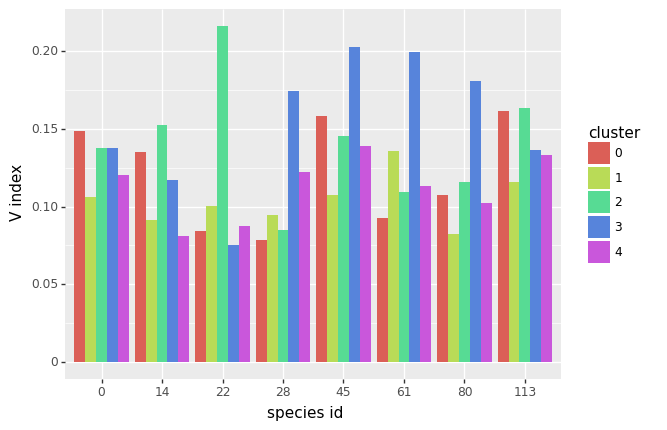

In [ ]:
# Alternatively, each species bar is build in descreasing order [ACTUALLY THE SAME]
df_ord = df
g = df_ord.groupby('rel_species', as_index=False)
df_ord = g.apply(lambda x: x.sort_values('V_index', ascending=False))
df_ord = df_ord.reset_index(drop=True)
# Stacked barplot with multiple groups
species_ord = ggplot(df_ord, aes("rel_species", "V_index", fill="cluster")) +  geom_bar(stat="identity", position="dodge") \
  + xlab("species id") + ylab("V index")
print(species_ord)